# Hands on with Graph Neural Networks

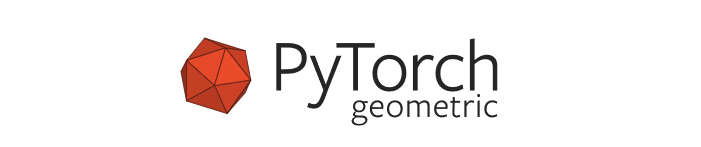

## Installing Pytorch Geometric and RDKit

- Pytorch Geometric => Build Graph Neural Network
- RDKit => Handle Molecule Data


_Note: Currently I didn't find a way to set a specific python version in colab. However, when installing rdkit, only specific python versions are supported... Hence it cannot be ensured that the notebook runs properly. For example Python 3.7.10 is not supported._

In [1]:
# Enforce pytorch version 1.6.0
import torch
!nvidia-smi

Thu Jul 27 06:04:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> Make sure you clicked "RESTART RUNTIME" above (if torch version was different)!

In [ ]:
# If something breaks in the notebook it is probably related to a mismatch between the Python version, CUDA or torch
import torch
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
!pip install rdkit

## Background info on the Dataset

In the following we will use a dataset provided in the dataset collection of PyTorch Geometric ([Here you find all datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)). The Dataset comes from the MoleculeNet collection, which can be found [here](http://moleculenet.ai/datasets-1).


>"ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset
has been used to train models that estimate solubility directly from chemical structures (as
encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since
solubility is a property of a molecule and not of its particular conformers."

**>>> Machine Learning task: How are different molecules dissolving in water?**


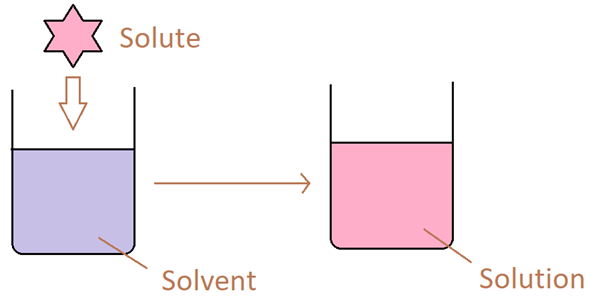

Source: https://www.differencebetween.com/difference-between-solubility-and-solubility-product/

### SMILES representation and important sidenodes

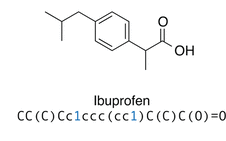

 Source: https://medium.com/@sunitachoudhary103/generating-molecules-using-a-char-rnn-in-pytorch-16885fd9394b

- Using the plain SMILES string as input is not suitable
- This will not consider the molecule structure but rather the grammar of the SMILES string
- The SMILES string can be different for a molecule, depending on the notation ( a unique molecule can have multiple SMILES strings )
- Chemical graphs however, are invariant to permutations --> Graph Neural Networks


## Looking into the Dataset

In [4]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [5]:
data.print_summary()

MoleculeNet (#graphs=1128):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     13.3 |     27.4 |
| std        |      6.9 |     15.9 |
| min        |      1   |      0   |
| quantile25 |      8   |     16   |
| median     |     12   |     24   |
| quantile75 |     18   |     38   |
| max        |     55   |    124   |
+------------+----------+----------+


In [19]:
print(data.data.x.shape),print(data.data.edge_attr.shape),print(data.data.y.shape)

torch.Size([14991, 9])
torch.Size([30856, 3])
torch.Size([1128, 1])


(None, None, None)

In [20]:
data.num_edge_features,data.num_features,data.data.keys

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(3, 9, ['edge_index', 'y', 'x', 'edge_attr', 'smiles'])

Note: There seems to be a change in the Dataset class and somehow the target dim now equals 734 instead of one. You can simply ignore it at this point. :)

In [21]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [35]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x.shape

torch.Size([32, 9])

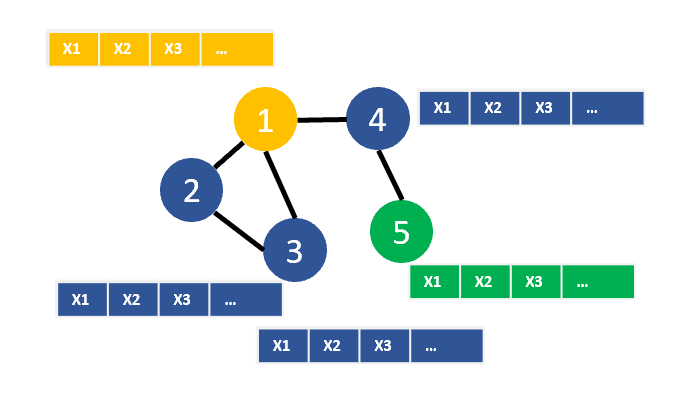

In [23]:
# Investigating the edges in sparse COO format
## [0,1] , [1,0] - it means edge of index 0 is connected to index 1 and similarly, index 1 is connected to 0.
# Shape [2, num_edges]
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [24]:
data[0].y

tensor([[-0.7700]])

In the following we will perform predictions based on the graph level. This means we have one y-label for the whole graph, as shown on the left image below. The right image would be node-level-predictions.

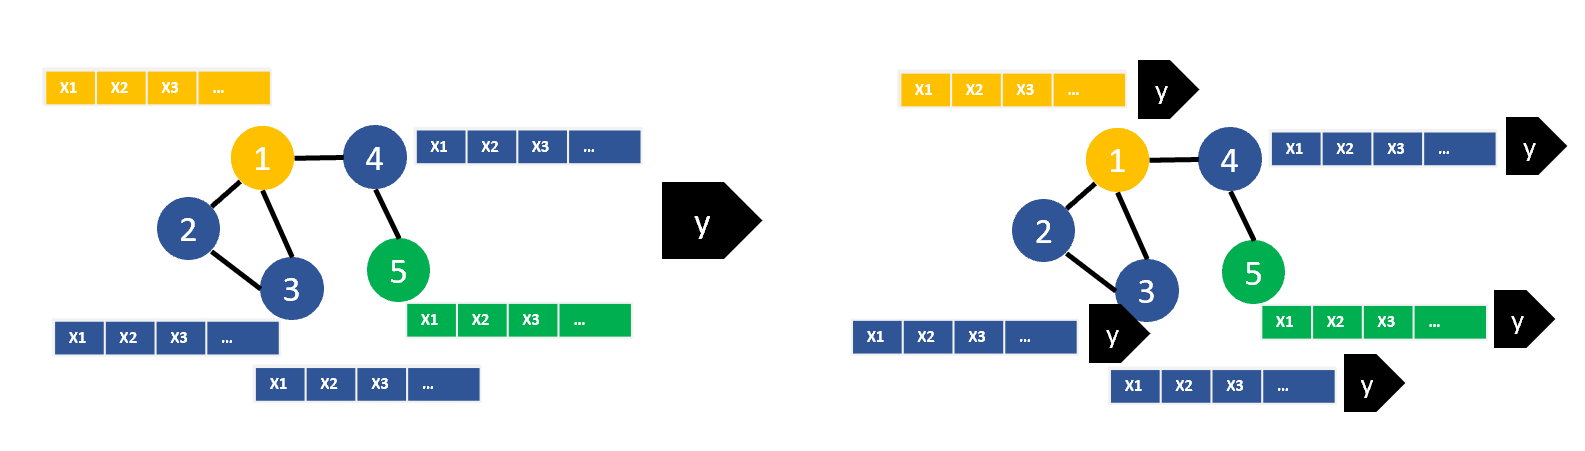

## Converting SMILES to RDKit molecules - Visualizing molecules

Next we want to have our SMILES molecules as graphs...

In [25]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

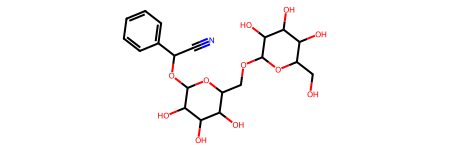

In [26]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [27]:
type(molecule)

rdkit.Chem.rdchem.Mol

- We can also obtain the features from this RDKit representation
- It tells us everything we need to know e.g. atom features (type, ...), edges, ...
- **In our case however, It's even easier as we have the information explicitly given already in the dataset**
- Otherwise we would calculate the node features from those atom properties

-> For datasets containing SMILES representations this would be the way to go

## Implementing the Graph Neural Network

Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

In [28]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


- We could also reduce the embeddings, but as we have large molecules we use 64
- The more layers we add, the more information we get about the graph
- For the regression problem we use a Linear layer as final output layer
- We try to use not too many parameters, as we only have ~1k samples

## Training the GNN

In [37]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 4.700295448303223
Epoch 100 | Train Loss 0.26796919107437134
Epoch 200 | Train Loss 0.2781792879104614
Epoch 300 | Train Loss 0.5656012296676636
Epoch 400 | Train Loss 0.3788211941719055
Epoch 500 | Train Loss 0.3232661783695221
Epoch 600 | Train Loss 0.06981810182332993
Epoch 700 | Train Loss 0.854656457901001
Epoch 800 | Train Loss 0.12148801982402802
Epoch 900 | Train Loss 0.08260583132505417
Epoch 1000 | Train Loss 0.35986003279685974
Epoch 1100 | Train Loss 0.4338191747665405
Epoch 1200 | Train Loss 0.20720529556274414
Epoch 1300 | Train Loss 0.06104438006877899
Epoch 1400 | Train Loss 0.1252422332763672
Epoch 1500 | Train Loss 0.06266405433416367
Epoch 1600 | Train Loss 0.054159849882125854
Epoch 1700 | Train Loss 0.19965797662734985
Epoch 1800 | Train Loss 0.028594665229320526
Epoch 1900 | Train Loss 0.013904225081205368


In [ ]:

for batch in loader:
  #print(batch.x.float().shape,batch.edge_index.shape,batch.batch.shape)
  print(batch.batch)


### Visualizing the Training loss

<Axes: >

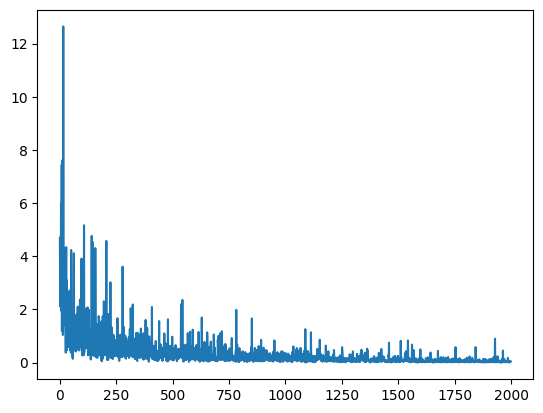

In [42]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(losses_float)
plt

### Getting a test prediction

In [43]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-0.590,-0.729835
1,-4.720,-4.426562
2,0.150,0.180343
3,-2.380,-1.431752
4,-1.210,-1.391236
...,...,...
59,-5.030,-6.551606
60,-6.800,-6.600012
61,-2.943,-2.130605
62,-7.390,-7.579260


<Axes: xlabel='y_real', ylabel='y_pred'>

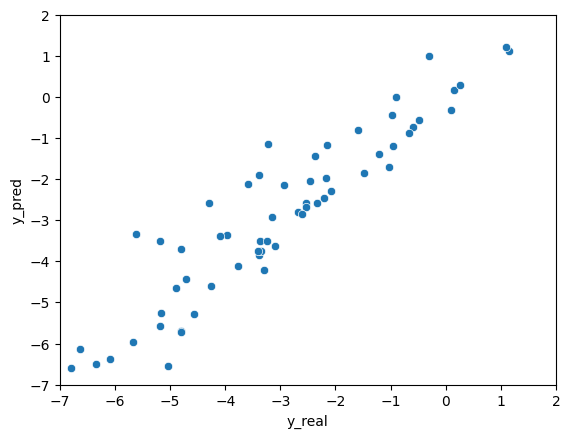

In [44]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

## Improving the model / More to play around with


For example you can add:
- Dropouts
- Other (more intelligent) Pooling Layers (all layers here: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#)
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization
- ...

https://github.com/rusty1s/pytorch_geometric/tree/master/examples